# **KAIST EE**
#  **[EE488] note 02B. CartPole (using a reinforcement learning library)**
## **Instructor**: Prof. Yoon, Young-Gyu (ygyoon@kaist.ac.kr)
### This example code was prepared by EE488 teaching assistants Han, Seungjae (jay0118@kaist.ac.kr) & Shin, Changyeop (scey26@kaist.ac.kr).

- Class Date : 22.03.xx.
- Office Hour : -----------
- If you have any questions, ask via KLMS Q&A board or come to TA office hour to get our help.

---

### 0. In this example, we will for solve CartPole (an inverted pendulum problem) again using a library called **Stable Baselines3** which provides multiple state-of-the-art reinforcement learning algorithms. This way, we can try multiple algorithms without having to to worry about any low level implementation of the algorithms


**Stable Baselines3**

Stable Baselines3 (SB3) is a set of reliable implementations of reinforcement learning algorithms in PyTorch. It is the next major version of Stable Baselines.

Github repository: https://github.com/DLR-RM/stable-baselines3

Paper: https://jmlr.org/papers/volume22/20-1364/20-1364.pdf
https://stable-baselines3.readthedocs.io/en/master/

Manual: https://stable-baselines3.readthedocs.io/_/downloads/en/master/pdf/



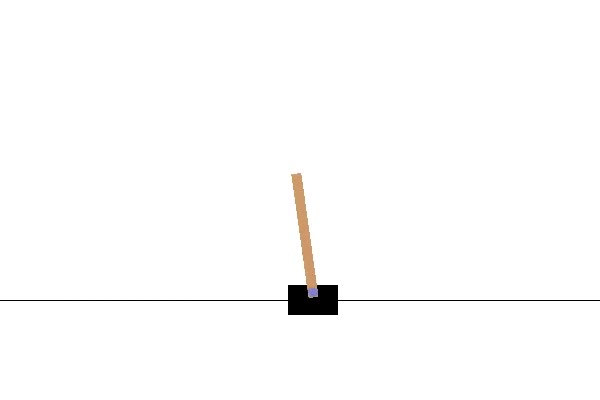


**CartPole-v1**
A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The system is controlled by applying a force of +1 or -1 to the cart. The pendulum starts upright, and the goal is to prevent it from falling over. A reward of +1 is provided for every timestep that the pole remains upright. The episode ends when the pole is more than 15 degrees from vertical, or the cart moves more than 2.4 units from the center.

https://gym.openai.com/envs/CartPole-v1/





### 1. Let's Install **stable-baselines3**.

In [ ]:
! pip install stable-baselines3[extra]

### 2. Let's **mount Google drive** so that we can save files as we need.

In [ ]:
from google.colab import drive
drive.mount("/content/drive")
import sys
import os

filepath = "/content/drive/My Drive//01_LectureNotes/EE488_AI_Capstone/Colab/"  # Change this path for your Google drive setting.
sys.path.append(filepath)
experiment = "CartPole_02B"

if not os.path.exists(f"{filepath}"):
    os.makedirs(f"{filepath}")
if not os.path.exists(f"{filepath}/{experiment}"):
    os.makedirs(f"{filepath}/{experiment}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).




### 3. Let's install a few more things to setup RL enviroment. 

In [ ]:
# install required system dependencies
! apt-get install -y xvfb x11-utils

# install required python dependencies (might need to install additional gym extras depending)
! pip install gym[box2d]==0.17.* pyvirtualdisplay==0.2.* PyOpenGL==3.1.* PyOpenGL-accelerate==3.1.*

# Followings are for visualization (as we are running on server without a physical display!)
!pip install gym pyvirtualdisplay
!apt-get install -y xvfb python-opengl ffmpeg

Reading package lists... Done
Building dependency tree       
Reading state information... Done
x11-utils is already the newest version (7.7+3build1).
xvfb is already the newest version (2:1.19.6-1ubuntu4.10).
The following package was automatically installed and is no longer required:
  libnvidia-common-470
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
python-opengl is already the newest version (3.1.0+dfsg-1).
ffmpeg is already the newest version (7:3.4.8-0ubuntu0.2).
xvfb is already the newest version (2:1.19.6-1ubuntu4.10).
The following package was automatically installed and is no longer required:
  libnvidia-common-470
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.


### 4.  And then, let's **import the libraries** (including stable-baselines3) we need to use.

In [ ]:
import gym
import torch

from stable_baselines3 import A2C, DQN, PPO
from stable_baselines3.common.env_util import make_atari_env
from stable_baselines3.common.vec_env import VecFrameStack
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import VecExtractDictObs, VecMonitor
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.vec_env import VecVideoRecorder
from stable_baselines3.common import results_plotter
from stable_baselines3.common.results_plotter import load_results, ts2xy, plot_results
from stable_baselines3.common.callbacks import BaseCallback

### 5. We need a bunch of stuff for **visualization** (as we are running on server without a physical display!). Let's not worry about the details here.

In [ ]:
from stable_baselines3.common.monitor import Monitor as TrainMonitor
from gym.wrappers import Monitor as EvalMonitor
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import io
import base64
from IPython.display import HTML, clear_output
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display

display = Display(visible=0, size=(400, 300))
display.start()

<Display cmd_param=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '400x300x24', ':1017'] cmd=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '400x300x24', ':1017'] oserror=None return_code=None stdout="None" stderr="None" timeout_happened=False>

### 6. Here's our function for visualization of the result as a **video**.

In [ ]:
def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    
def wrap_env(env):
  env = EvalMonitor(env, './video', force=True)
  return env

### 7. Here's a function to **check the training process**. 

In [ ]:
class SaveOnBestTrainingRewardCallback(BaseCallback):
    """
    Callback for saving a model (the check is done every ``check_freq`` steps)
    based on the training reward (in practice, we recommend using ``EvalCallback``).

    :param check_freq:
    :param log_dir: Path to the folder where the model will be saved.
      It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: Verbosity level.
    """
    def __init__(self, check_freq: int, log_dir: str, verbose: int = 1):
        super(SaveOnBestTrainingRewardCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, 'best_model')
        self.best_mean_reward = -np.inf

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:

          # Retrieve training reward
          x, y = ts2xy(load_results(self.log_dir), 'timesteps')
          if len(x) > 0:
              # Mean training reward over the last 100 episodes
              mean_reward = np.mean(y[-100:])
              if self.verbose > 0:
                print(f"Num timesteps: {self.num_timesteps}")
                print(f"Best mean reward: {self.best_mean_reward:.2f} - Last mean reward per episode: {mean_reward:.2f}")

              # New best model, you could save the agent here
              if mean_reward > self.best_mean_reward:
                  self.best_mean_reward = mean_reward
                  # Example for saving best model
                  if self.verbose > 0:
                    print(f"Saving new best model to {self.save_path}")
                  self.model.save(self.save_path)

        return True

### 8. Let's start **training DQN**. This is pretty much all we need (everything is encapsulated in stable-baselines3). Of course, you can easily change the hyperparameters if you want. See the manual below. 

https://stable-baselines3.readthedocs.io/_/downloads/en/master/pdf/

Below shows the list of hyperparameters we can change.

**DQN**(policy, env, learning_rate=0.0001, buffer_size=1000000,
learning_starts=50000, batch_size=32, tau=1.0, gamma=0.99,
train_freq=4, gradient_steps=1, replay_buffer_class=None,
replay_buffer_kwargs=None, optimize_memory_usage=False,
target_update_interval=10000, exploration_fraction=0.1,
exploration_initial_eps=1.0, exploration_final_eps=0.05,
max_grad_norm=10, tensorboard_log=None, create_eval_env=False,
policy_kwargs=None, verbose=0, seed=None, device='auto',
_init_setup_model=True)


Using cpu device
Wrapping the env in a DummyVecEnv.
Num timesteps: 10000
Best mean reward: -inf - Last mean reward per episode: 22.76
Saving new best model to /tmp/gym/best_model
Num timesteps: 20000
Best mean reward: 22.76 - Last mean reward per episode: 23.12
Saving new best model to /tmp/gym/best_model
Num timesteps: 30000
Best mean reward: 23.12 - Last mean reward per episode: 23.18
Saving new best model to /tmp/gym/best_model
Num timesteps: 40000
Best mean reward: 23.18 - Last mean reward per episode: 23.20
Saving new best model to /tmp/gym/best_model
Num timesteps: 50000
Best mean reward: 23.20 - Last mean reward per episode: 23.33
Saving new best model to /tmp/gym/best_model
Num timesteps: 60000
Best mean reward: 23.33 - Last mean reward per episode: 11.69
Num timesteps: 70000
Best mean reward: 23.33 - Last mean reward per episode: 14.61
Num timesteps: 80000
Best mean reward: 23.33 - Last mean reward per episode: 16.45
Num timesteps: 90000
Best mean reward: 23.33 - Last mean rew

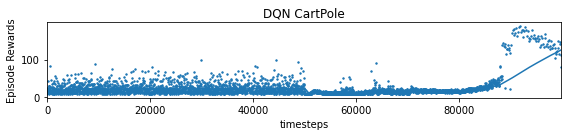

In [ ]:
# env = make_atari_env('CartPole-v1', n_envs=1, seed=0)
env = gym.make('CartPole-v1')

# Create log dir
log_dir = "/tmp/gym/"
os.makedirs(log_dir, exist_ok=True)

# Create and wrap the environment
env = TrainMonitor(gym.make('CartPole-v1'), log_dir)
model = DQN('MlpPolicy', env, buffer_size=int(1e4), verbose=1)

# See below to check the list of hyperparameters we can control
# DQN(policy, env, learning_rate=0.0001, buffer_size=1000000, 
# learning_starts=50000, batch_size=32, tau=1.0, gamma=0.99,
# train_freq=4, gradient_steps=1, replay_buffer_class=None,
# replay_buffer_kwargs=None, optimize_memory_usage=False,
# target_update_interval=10000, exploration_fraction=0.1,
# exploration_initial_eps=1.0, exploration_final_eps=0.05,
# max_grad_norm=10, tensorboard_log=None, create_eval_env=False,
# policy_kwargs=None, verbose=0, seed=None, device='auto',
# _init_setup_model=True)


# Create the callback: check every 1000 steps
callback = SaveOnBestTrainingRewardCallback(check_freq=10000, log_dir=log_dir)

timesteps = int(1e5)
model.learn(total_timesteps=timesteps, callback = callback, eval_freq=10000, log_interval=10000)

plot_results([log_dir], timesteps, results_plotter.X_TIMESTEPS, "DQN CartPole")
plt.show()

### 9. Now, let's **evaluate** the performance of the trained network (DQN)!

In [ ]:
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3 import A2C, DQN, PPO

env_id = 'CartPole-v1'

# Evaluate the agent
env = wrap_env(gym.make(env_id))

# model = PPO.load('SAVED_PATH', env)

# mean_reward, std_reward = evaluate_policy(model, model.get_env(), n_eval_episodes=10)
# print(mean_reward, std_reward)

# Enjoy trained agent
obs = env.reset()

while True:
    action, _states = model.predict(obs, deterministic=False)
    obs, rewards, dones, info = env.step(action)
    env.render()
    if dones == True:
        break
env.close()
show_video()

### **Congratulations**! You sucessfully trained a DQN using stable-baselines3.

---

### 10. Let's just try one more thing. The point of using library is to make our lives easier...so let's see how easy it is. Below is all we need to train the agent using PPO algorithm.

**PPO**(policy, env, learning_rate=0.0003, n_steps=2048, batch_size=64,
n_epochs=10, gamma=0.99, gae_lambda=0.95, clip_range=0.2,
clip_range_vf=None, normalize_advantage=True, ent_coef=0.0,
vf_coef=0.5, max_grad_norm=0.5, use_sde=False, sde_sample_freq=- 1,
target_kl=None, tensorboard_log=None, create_eval_env=False,
policy_kwargs=None, verbose=0, seed=None, device='auto',
_init_setup_model=True)

Using cpu device
Wrapping the env in a DummyVecEnv.
Num timesteps: 10000
Best mean reward: -inf - Last mean reward per episode: 55.92
Saving new best model to /tmp/gym/best_model
Num timesteps: 20000
Best mean reward: 55.92 - Last mean reward per episode: 141.81
Saving new best model to /tmp/gym/best_model
Num timesteps: 30000
Best mean reward: 141.81 - Last mean reward per episode: 227.62
Saving new best model to /tmp/gym/best_model
Num timesteps: 40000
Best mean reward: 227.62 - Last mean reward per episode: 316.83
Saving new best model to /tmp/gym/best_model
Num timesteps: 50000
Best mean reward: 316.83 - Last mean reward per episode: 393.41
Saving new best model to /tmp/gym/best_model
Num timesteps: 60000
Best mean reward: 393.41 - Last mean reward per episode: 460.22
Saving new best model to /tmp/gym/best_model
Num timesteps: 70000
Best mean reward: 460.22 - Last mean reward per episode: 487.72
Saving new best model to /tmp/gym/best_model
Num timesteps: 80000
Best mean reward: 487

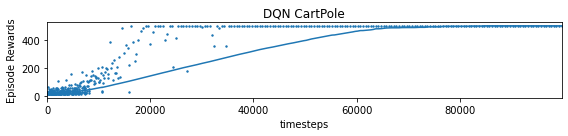

In [ ]:
env = gym.make('CartPole-v1')

# Create log dir
log_dir = "/tmp/gym/"
os.makedirs(log_dir, exist_ok=True)

# Create and wrap the environment
env = TrainMonitor(gym.make('CartPole-v1'), log_dir)
model2 = PPO('MlpPolicy', env, verbose=1)

# See below to check the list of hyperparameters we can control
# PPO(policy, env, learning_rate=0.0003, n_steps=2048, batch_size=64,
# n_epochs=10, gamma=0.99, gae_lambda=0.95, clip_range=0.2,
# clip_range_vf=None, normalize_advantage=True, ent_coef=0.0,
# vf_coef=0.5, max_grad_norm=0.5, use_sde=False, sde_sample_freq=- 1,
# target_kl=None, tensorboard_log=None, create_eval_env=False,
# policy_kwargs=None, verbose=0, seed=None, device='auto',
# _init_setup_model=True)


# Create the callback: check every 1000 steps
callback = SaveOnBestTrainingRewardCallback(check_freq=10000, log_dir=log_dir)

timesteps = int(1e5)
model2.learn(total_timesteps=timesteps, callback = callback, eval_freq=10000, log_interval=10000)

plot_results([log_dir], timesteps, results_plotter.X_TIMESTEPS, "DQN CartPole")
plt.show()

### 11. Again, let's **evaluate** the performance of the trained network (PPO)!

In [ ]:
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3 import A2C, DQN, PPO

env_id = 'CartPole-v1'

# Evaluate the agent
env = wrap_env(gym.make(env_id))

# model = PPO.load('SAVED_PATH', env)

# mean_reward, std_reward = evaluate_policy(model, model.get_env(), n_eval_episodes=10)
# print(mean_reward, std_reward)

# Enjoy trained agent
obs = env.reset()

while True:
    action, _states = model2.predict(obs, deterministic=False)
    obs, rewards, dones, info = env.step(action)
    env.render()
    if dones == True:
        break
env.close()
show_video()